# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

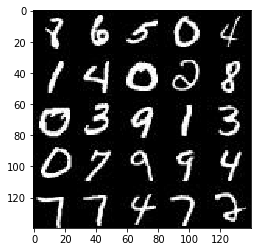

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

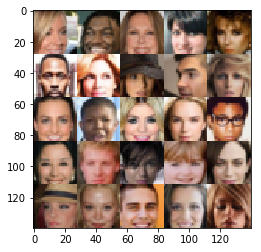

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/manopaul/anaconda/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return inputs_real, inputs_z, lr 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3 - starting image dimensions
        # Using Xavier_Initializer as per project reviewer's feedback to break symmetry and make model converge faster
        d_layer1 = tf.layers.conv2d(images, 64,5, strides=2, padding='SAME',
                                   kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True,
                                                                                          seed=None,
                                                                                          dtype=tf.float32
                                                                                          ))
        relu1 = tf.maximum(alpha * d_layer1, d_layer1)
        # 14x14x64
        
        d_layer2 = tf.layers.conv2d(d_layer1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(d_layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        d_layer3 = tf.layers.conv2d(d_layer2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(d_layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # Dropout
        relu3_drop = tf.nn.dropout(relu3, 0.8)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3_drop, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        g_layer1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        g_layer1 = tf.reshape(g_layer1, (-1, 7,7,256))
        g_layer1 = tf.layers.batch_normalization(g_layer1, training=is_train)
        g_layer1 = tf.maximum(alpha * g_layer1, g_layer1)
        # 7x7x256
        
        g_layer2 = tf.layers.conv2d_transpose(g_layer1, 128, 5, strides=2, padding='SAME', 
                                              kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True,
                                                                                          seed=None,
                                                                                          dtype=tf.float32
                                                                                          ))
        g_layer2 = tf.layers.batch_normalization(g_layer2, training=is_train)
        g_layer2 = tf.maximum(alpha * g_layer2, g_layer2)
        # 14x14x128
        
        g_layer3 = tf.layers.conv2d_transpose(g_layer2, 64, 5, strides=2, padding='SAME')
        g_layer3 = tf.layers.batch_normalization(g_layer3, training=is_train)
        g_layer3 = tf.maximum(alpha * g_layer3, g_layer3)
        # Dropout
        g_layer3_drop = tf.nn.dropout(g_layer3, 0.8)
        # 28x28x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(g_layer3_drop, out_channel_dim, 5, strides=1, padding='SAME')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth_factor = 0.9 # Factor to smooth out real input labels to discriminator to improve performance of discriminator
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth_factor))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    data_image_mode="RGB"
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    # Print losses at end of each epoch
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    if image_depth == 1:
                            data_image_mode= "L"
                    show_generator_output(sess, 10, input_z, image_depth, data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')

    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 17.3000
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 5.1260
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 5.3203
Epoch 1/2... Discriminator Loss: 0.4546... Generator Loss: 2.8414
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 2.8929
Epoch 1/2... Discriminator Loss: 0.3498... Generator Loss: 6.1326
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 6.0476
Epoch 1/2... Discriminator Loss: 0.3533... Generator Loss: 5.9829
Epoch 1/2... Discriminator Loss: 0.3657... Generator Loss: 11.5451
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 1.1245


Epoch 1/2... Discriminator Loss: 0.6956... Generator Loss: 3.5735
Epoch 1/2... Discriminator Loss: 0.6095... Generator Loss: 2.4189
Epoch 1/2... Discriminator Loss: 1.6347... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 0.6516... Generator Loss: 1.7787
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 3.4566
Epoch 1/2... Discriminator Loss: 3.1507... Generator Loss: 0.1060
Epoch 1/2... Discriminator Loss: 1.9910... Generator Loss: 0.3827
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 2.0247... Generator Loss: 0.2894
Epoch 1/2... Discriminator Loss: 1.6484... Generator Loss: 0.5307


Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.0294
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 1.1187
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 1.2158
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.9871
Epoch 1/2... Discriminator Loss: 1.5091... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 1.7094... Generator Loss: 0.3917
Epoch 1/2... Discriminator Loss: 1.6631... Generator Loss: 0.4102


Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 1.0357
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.9178
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.3487
Epoch 1/2... Discriminator Loss: 1.6298... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.7010


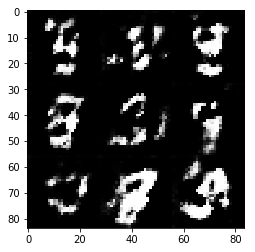

Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 0.9097... Generator Loss: 1.7011
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.4354
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 0.9719
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.8043
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.7993


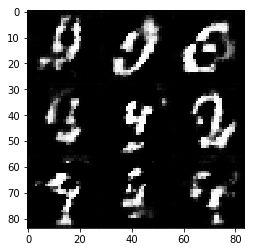

Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.0558
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 1.3706
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.9086
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.0746
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.7586


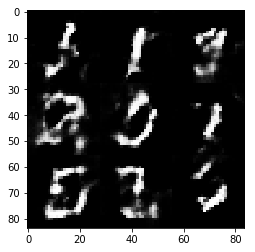

Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 1.1200
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.9099
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.2745... Generator Loss: 0.9052
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.9877


Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 1.1015
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.8751
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 1.0110
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.6949


Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 1.3733... Generator Loss: 0.6269
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.9410


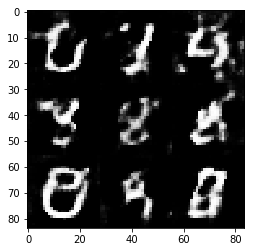

Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.9534
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 1.1281
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 1.4236... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.9608


Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 1.1649... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.2430... Generator Loss: 0.9523


Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 0.9479
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.2716... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.8511
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.7740


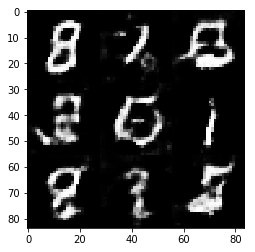

Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 1.0622


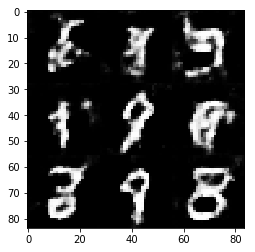

Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 0.9388
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.8865
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.7658


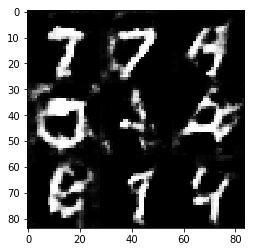

Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 1.2968... Generator Loss: 0.6643
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.9359


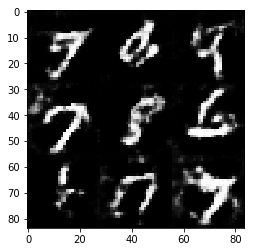

Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.2803... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.8625
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.9346
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 1.0298


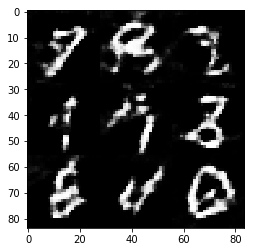

Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.9019
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.6319
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.8001


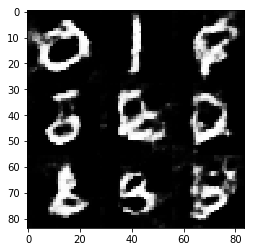

Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.8180


Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.8511
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 1.0139


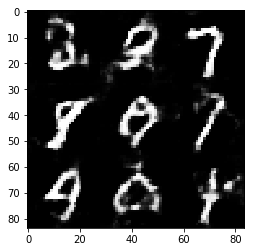

Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.3854... Generator Loss: 0.9429
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 1.2447... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.8488
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.9990


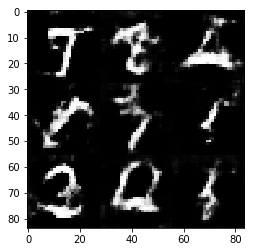

Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.6324
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 1.0323
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 0.7714
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.8807
Epoch 2/2... Discriminator Loss: 1.3011... Generator Loss: 0.7975


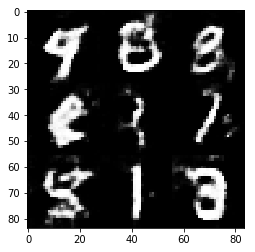

Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8984
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.6117
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.7908
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.8612


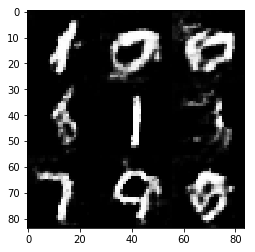

Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.9059


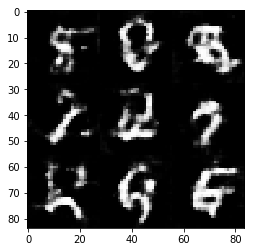

Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.9001
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.9113


Epoch 2/2... Discriminator Loss: 1.4083... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 1.2422... Generator Loss: 0.9862
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 1.0861


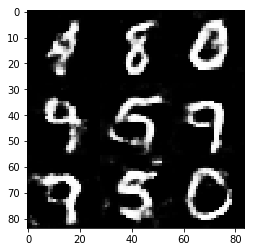

Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 1.0936
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.9790
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.9102
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.7511
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 1.0557


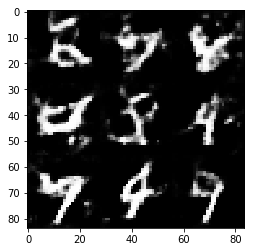

Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8833
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.9574
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.8392
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.8559


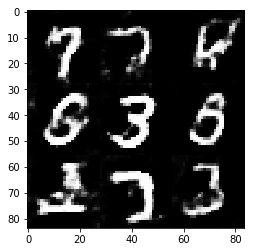

Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.4211... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 1.0659
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.7593


Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.8183
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.8655
Epoch 2/2... Discriminator Loss: 1.2051... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.3727... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 1.0098


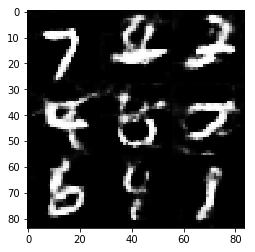

Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.9505
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.8341


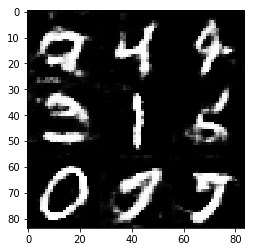

Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.8536
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.7640


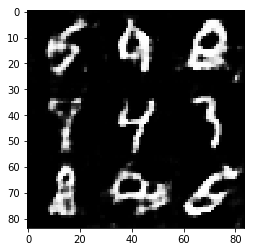

Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.8950
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 1.3843... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 1.0341
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 1.1798


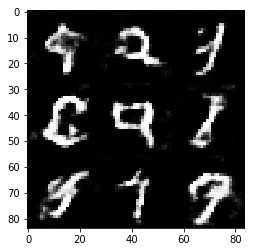

Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.8349
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 1.2015... Generator Loss: 0.9268
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 1.2795... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.3317... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.8852


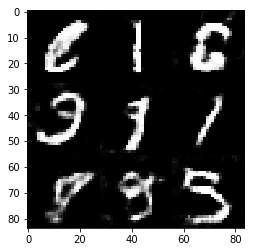

Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.9101
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.9274


Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 1.0047
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.6885


Epoch 2/2... Discriminator Loss: 1.3423... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.8105


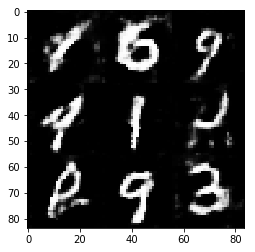

Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.3571... Generator Loss: 0.9890
Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.9109


Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.8132
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.0008


In [15]:
batch_size = 32 #128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 4.7753
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 17.5300
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 12.5586
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 8.9710
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 5.2763
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 9.2501
Epoch 1/1... Discriminator Loss: 0.3681... Generator Loss: 13.6605
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 3.1052
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 11.1034
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.0336


Epoch 1/1... Discriminator Loss: 0.5258... Generator Loss: 2.3597
Epoch 1/1... Discriminator Loss: 1.7816... Generator Loss: 7.8531
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.7903
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 1.7961
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 2.4329... Generator Loss: 4.3354
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.5850


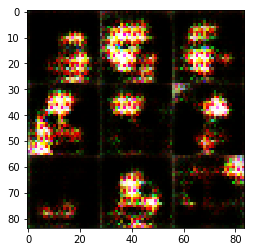

Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 2.3837
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 3.2447
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.2436


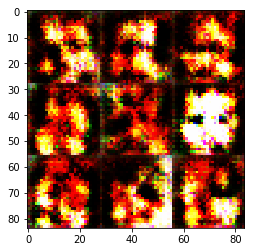

Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 2.1731
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 2.6729
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 2.3310
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 3.1455
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 4.8058
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.6740
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 3.7736
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 3.3083
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 3.5162


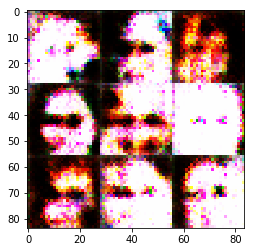

Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.5590
Epoch 1/1... Discriminator Loss: 0.3682... Generator Loss: 4.1506
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 2.4447... Generator Loss: 0.2080
Epoch 1/1... Discriminator Loss: 0.5006... Generator Loss: 3.0260
Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 2.7114
Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.0566
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 3.3038
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.5110


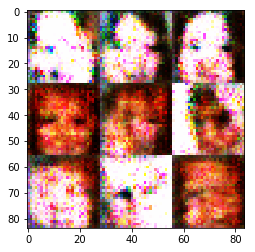

Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 3.0141
Epoch 1/1... Discriminator Loss: 3.0716... Generator Loss: 4.4498
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 4.3574
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.7034
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 2.9846
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.0248
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 3.9429
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 3.4373


Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.7591
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.3284
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.2031
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.2282
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 4.0081
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 3.6656
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 4.1171


Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.3843
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 2.9281
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.6278... Generator Loss: 4.7884
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 3.2769
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 3.3327
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 2.6083
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 2.4366


Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 2.4235
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 2.8457
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 2.6549
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 2.9783
Epoch 1/1... Discriminator Loss: 0.4268... Generator Loss: 2.8011
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 2.1003
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 2.1527
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 2.1002


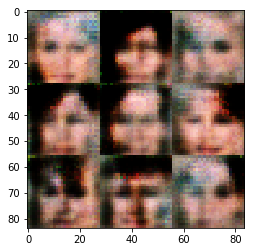

Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 2.1644
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 2.9202
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 1.9371
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 3.5742
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 2.2325
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.3265


Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.6853
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 2.0781
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 3.7815
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6939


Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.4652
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.4828
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.5756
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.5679


Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 1.8347
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 2.0935... Generator Loss: 0.3766
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 2.5226
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.5491


Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.7138... Generator Loss: 2.7186
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.0479


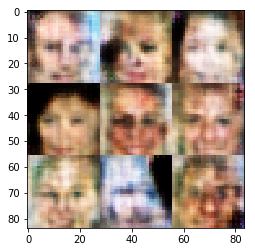

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.5341
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.5424
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 2.0709
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.7882
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.5829


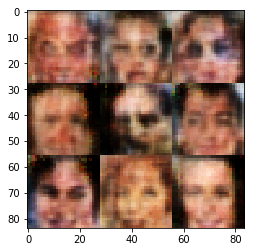

Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.5864
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 2.0509
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 2.1586... Generator Loss: 0.1744
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 2.5949


Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 2.2462... Generator Loss: 0.2783
Epoch 1/1... Discriminator Loss: 2.1045... Generator Loss: 2.5085
Epoch 1/1... Discriminator Loss: 1.6972... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.6426
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 1.7294
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.0333


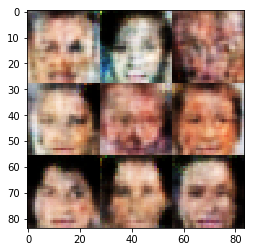

Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.3999
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.7660


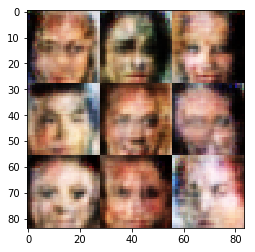

Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 1.6996
Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.3254


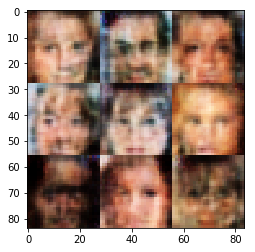

Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.5802
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.9629
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.6137
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.4490


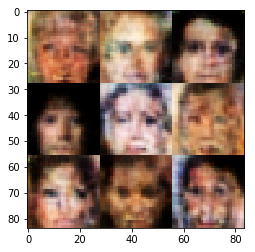

Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.8194
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.6996
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.9705
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.6484


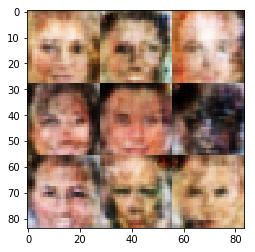

Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 2.1398
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.8441
Epoch 1/1... Discriminator Loss: 2.2697... Generator Loss: 3.1160
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 1.9865
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.0887


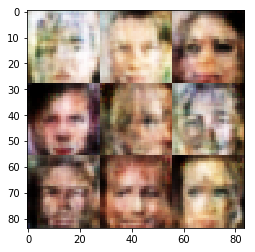

Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 1.7907
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.6785


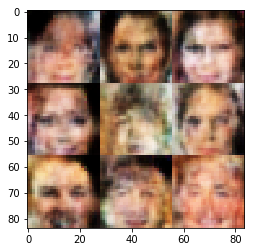

Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 1.6340
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.4704


In [ ]:
batch_size = 16 #128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.